# Statistical Anomaly Detection on Machine Temperature Data

This notebook applies statistical anomaly detection methods to the NAB machine temperature dataset.  
Statistical approaches are attractive because they are fast, interpretable, and useful as baselines before moving to machine learning or deep learning.  

Their main drawback is sensitivity to noise and missing contextual or neighborhood behavior. This means that an anomaly may appear normal when compared to the overall distribution but still stand out when evaluated relative to nearby values.


##Methods Considered

- **Global Detectors**  
  - Z-score: flags points that are *k* standard deviations away from the mean.  
  - IQR (Interquartile Range): marks values outside \[Q1 − 1.5×IQR, Q3 + 1.5×IQR].  
  - MAD (Median Absolute Deviation): a robust version of z-score based on medians.  
  These methods work well for detecting extreme spikes or drops in the full distribution.

I also tested local methods like rolling z-score, sequential methods like EWMA (Exponentially Weighted Moving Average). All showed very low recall and F1-scores, confirming that they are not effective for sudden failure patterns in this dataset.  

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pathlib

repo_root = pathlib.Path.cwd().resolve().parents[1]  
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# utils from this repo
from configs.config import DEFAULTS
from utils.data_loader import load_dataset
from utils.detectors_stats import run_detectors
from utils.visualizations import plot_methods_subplots 
from utils.evaluation import evaluate_predictions


def adapt_config(defaults):
    cfg = {"stats_global":{}, "stats_local":{}, "stats_sequential":{}, "stats_trend":{}}
    for section, sub in defaults.items():
        if section not in cfg:
            continue
        for key, opts in sub.items():
            if isinstance(opts, dict) and "enabled" in opts:
                if opts["enabled"]:
                    cfg[section][key] = {k:v for k,v in opts.items() if k != "enabled"}
    return cfg

config = adapt_config(DEFAULTS)

## Load Dataset

In [2]:
dfs, merged, failure_windows= load_dataset("machine_temperature")
df = dfs[0]

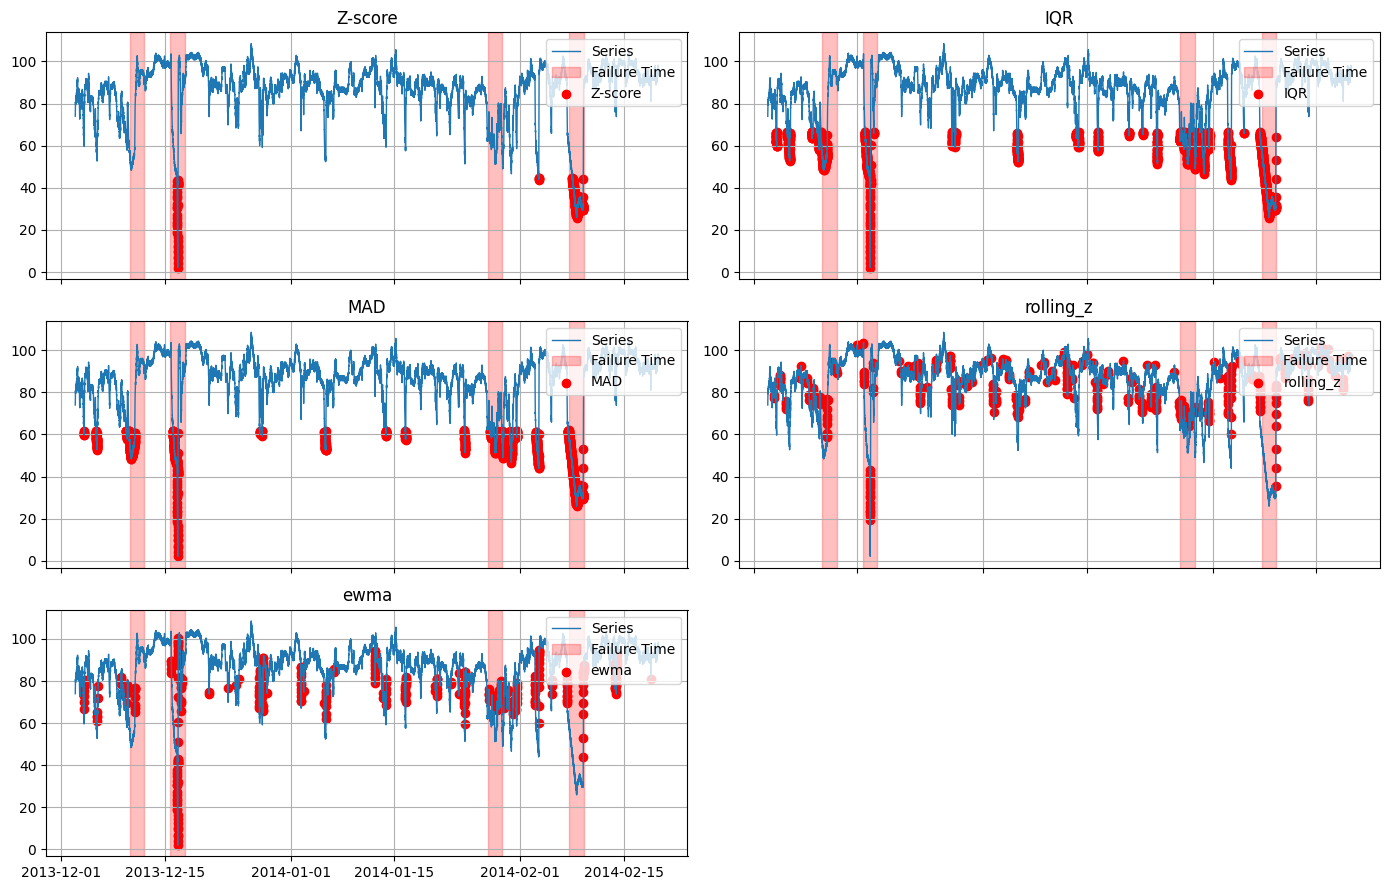

In [3]:
results = run_detectors(df, "machine_temperature_system_failure", config)
methods_preds = {name: res["mask"].astype(int) if "mask" in res else None
                 for name,res in results["per_method"].items()}
plot_methods_subplots(df, methods_preds, value_col="machine_temperature_system_failure", windows=failure_windows)

In [4]:
eval_results = {}
for name, res in results["per_method"].items():
    if "mask" in res:
        eval_results[name] = evaluate_predictions(df, res['mask'], failure_windows, early_tolerance="5h")
        
print(pd.DataFrame(eval_results).T.round(3).sort_values('f1', ascending=False))

               tp     fp      fn       tn  precision  recall     f1  \
IQR        1333.0  965.0   935.0  19462.0      0.580   0.588  0.584   
MAD        1126.0  622.0  1142.0  19805.0      0.644   0.496  0.561   
Z-score     458.0    4.0  1810.0  20423.0      0.991   0.202  0.336   
ewma        101.0  262.0  2167.0  20165.0      0.278   0.045  0.077   
rolling_z    73.0  350.0  2195.0  20077.0      0.173   0.032  0.054   

           anomaly_window_detection_rate  early_detection_rate  
IQR                                  1.0                  0.75  
MAD                                  1.0                  0.50  
Z-score                              0.5                  0.00  
ewma                                 1.0                  0.00  
rolling_z                            1.0                  0.25  


## Performance Summary

- **IQR** showed the best overall balance of precision and recall, making it the most reliable statistical baseline. It achieved full anomaly window detection rate (1), detecting at least one anomaly in all four anomaly windows, and had the highest early detection rate (0.75), successfully identifying anomalies before onset.

- **MAD** achieved higher precision with fewer false positives, but at the cost of lower recall, missing more true anomalies. Like IQR, it achieved full anomaly window detection rate (1) but its early detection rate was lower (0.5), showing less effectiveness in catching anomalies early.

- **Z-score** acted as a very strict detector, producing excellent precision but poor recall, since it only captured the most extreme drops. Its anomaly window detection rate was only 0.5, meaning it missed half of the anomaly periods (2 anomaly windows). Its early detection rate (0) also shows that it failed to flag anomalies before they became severe.

- **Rolling z-score** and **EWMA** performed poorly, with very low recall and F1-scores. While they technically had full anomaly window detection rate (1), they missed most points within the failure windows. Their early detection rates (0.25 and 0, respectively) confirm they were ineffective at early detection, particularly since anomalies in this dataset appear as sudden drops, which local and sequential methods are not well-suited to capture.

Based on these results, we will focus on IQR, MAD, and Z-score as the primary statistical baselines for comparison with machine learning and deep learning methods on this dataset.

### Metric Meanings
- Precision – Of all the points flagged as anomalies, how many were correct.
- Recall – Of all true anomaly points, how many were detected.
- F1-score – representing both precision and recall, balancing the trade-off.
- Anomaly Window Detection Rate – Fraction of anomaly windows (here, 4 total) where the detector caught at least one anomaly.
- Early Detection Rate – Fraction of anomaly windows where the detector raised a flag earlier than the labeld failure window.